In [1]:
from collections import defaultdict
from statistics import median, mean
import copy

import numpy as np
import pandas as pd
import wandb
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

from functools import cache
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

/var/folders/cr/7bwr934100dbcxzchhysy1m80000gn/T/ipykernel_15108/1661552739.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
api = wandb.Api(timeout=35)

@cache
def cached_history(path, samples):
    run = api.run(path)
    history = run.history(samples=samples)
    return history

@cache
def get_avg_value(path, x_name='_step', from_x=6300000, to_x=6400000, y_name='rmean_episode_return'):
    history = cached_history(path, 3000)
    try:
        rows = history[(history[x_name] >= from_x) & (history[x_name] <= to_x)]
        return rows[y_name].mean()
    except KeyError:
        return pd.NA


In [3]:
human_readable_env_names = {
    'knapsack-20x9-v0': "Subset Sum",
    'knapsack-20x9-v2': "Knapsack",
    'knapsack-20x9-bonus-v3': "Knapsack w/Bonus",
    'knapsack-20x9-bonus2-v3': "Knapsack w/Bonus=2",
    'Sokoban-v0': 'Sokoban',
    'subset-sum-20x9-bonus-v0': 'Subset Sum w/Bonus',
}

TIMED_RETURNS_NAME = "Compute-Dependent Returns"

flexible k	- Rows have different values for `ray_cpu`: {8, 10}
flexible k	- Rows have different values for `fixed_step_cost`: {-0.016, -0.00025, -0.001, -0.0015, -0.002, -0.0005, 0, -0.004, -0.008}
mcts	- Rows have different values for `rec_t`: {100, 25, 50, 12}
mcts	- Rows have different values for `ray_cpu`: {12, 14}
mcts	- Rows have different values for `buffer_traj_len`: {50, 20}
fixed k	- Rows have different values for `rec_t`: {3, 4, 6, 9, 13, 19}
model free rl	- Rows have different values for `ray_cpu`: {11, 14}
model free rl	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}


18it [00:17,  1.03it/s]
1it [00:00,  1.18it/s]

approximating rmean_episode_steps



2it [00:01,  1.32it/s]

approximating rmean_episode_steps



3it [00:02,  1.37it/s]

approximating rmean_episode_steps



4it [00:02,  1.35it/s]

approximating rmean_episode_steps



5it [00:03,  1.37it/s]

approximating rmean_episode_steps



6it [00:04,  1.39it/s]

approximating rmean_episode_steps



7it [00:05,  1.32it/s]

approximating rmean_episode_steps



8it [00:06,  1.25it/s]

approximating rmean_episode_steps



9it [00:06,  1.23it/s]

approximating rmean_episode_steps



10it [00:07,  1.21it/s]

approximating rmean_episode_steps


12it [00:08,  1.61it/s]

approximating rmean_episode_steps
approximating rmean_episode_steps
100
'rmean_adj_episode_return'


15it [00:10,  1.39it/s]
100it [01:11,  1.39it/s]
/var/folders/cr/7bwr934100dbcxzchhysy1m80000gn/T/ipykernel_15108/194522703.py:164: RuntimeWarning: Mean of empty slice
  average_values = np.nanmean(interpolated_values[y_label], axis=0)
/var/folders/cr/7bwr934100dbcxzchhysy1m80000gn/T/ipykernel_15108/194522703.py:229: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


{-0.016: {'flex': (nan, nan, 0),
  'fixed': [(3, 1.1643638595457484, 0),
   (4, 1.2543374325825274, 0),
   (6, 1.3647247270552942, 0),
   (9, 1.3253188593097882, 0),
   (13, 1.1773075766099868, 0),
   (19, 0.8528130994115125, 0)],
  'model-free': None,
  'mcts': [(12, -4.692695964529219, 0),
   (25, -2.851174552788004, 0),
   (50, -2.8916133540929483, 0),
   (100, nan, 0)]},
 -0.008: {'flex': (3.8012074895665906, 1.2342182217216136, 0),
  'fixed': [(3, 1.268907710127512, 0),
   (4, 1.3839052206571893, 0),
   (6, 1.5463671458587043, 0),
   (9, 1.594351090637308, 0),
   (13, 1.5494449797349183, 0),
   (19, 1.3901204052888496, 0)],
  'model-free': None,
  'mcts': [(12, -3.0092985552168887, 0),
   (25, -1.27746594956887, 0),
   (50, -0.7581147472977342, 0),
   (100, nan, 0)]},
 -0.004: {'flex': (7.316395750680708, 1.769298744799869, 0),
  'fixed': [(3, 1.3211796354183936, 0),
   (4, 1.4486891146945204, 0),
   (6, 1.6371883552604094, 0),
   (9, 1.728867206301068, 0),
   (13, 1.7355136812973

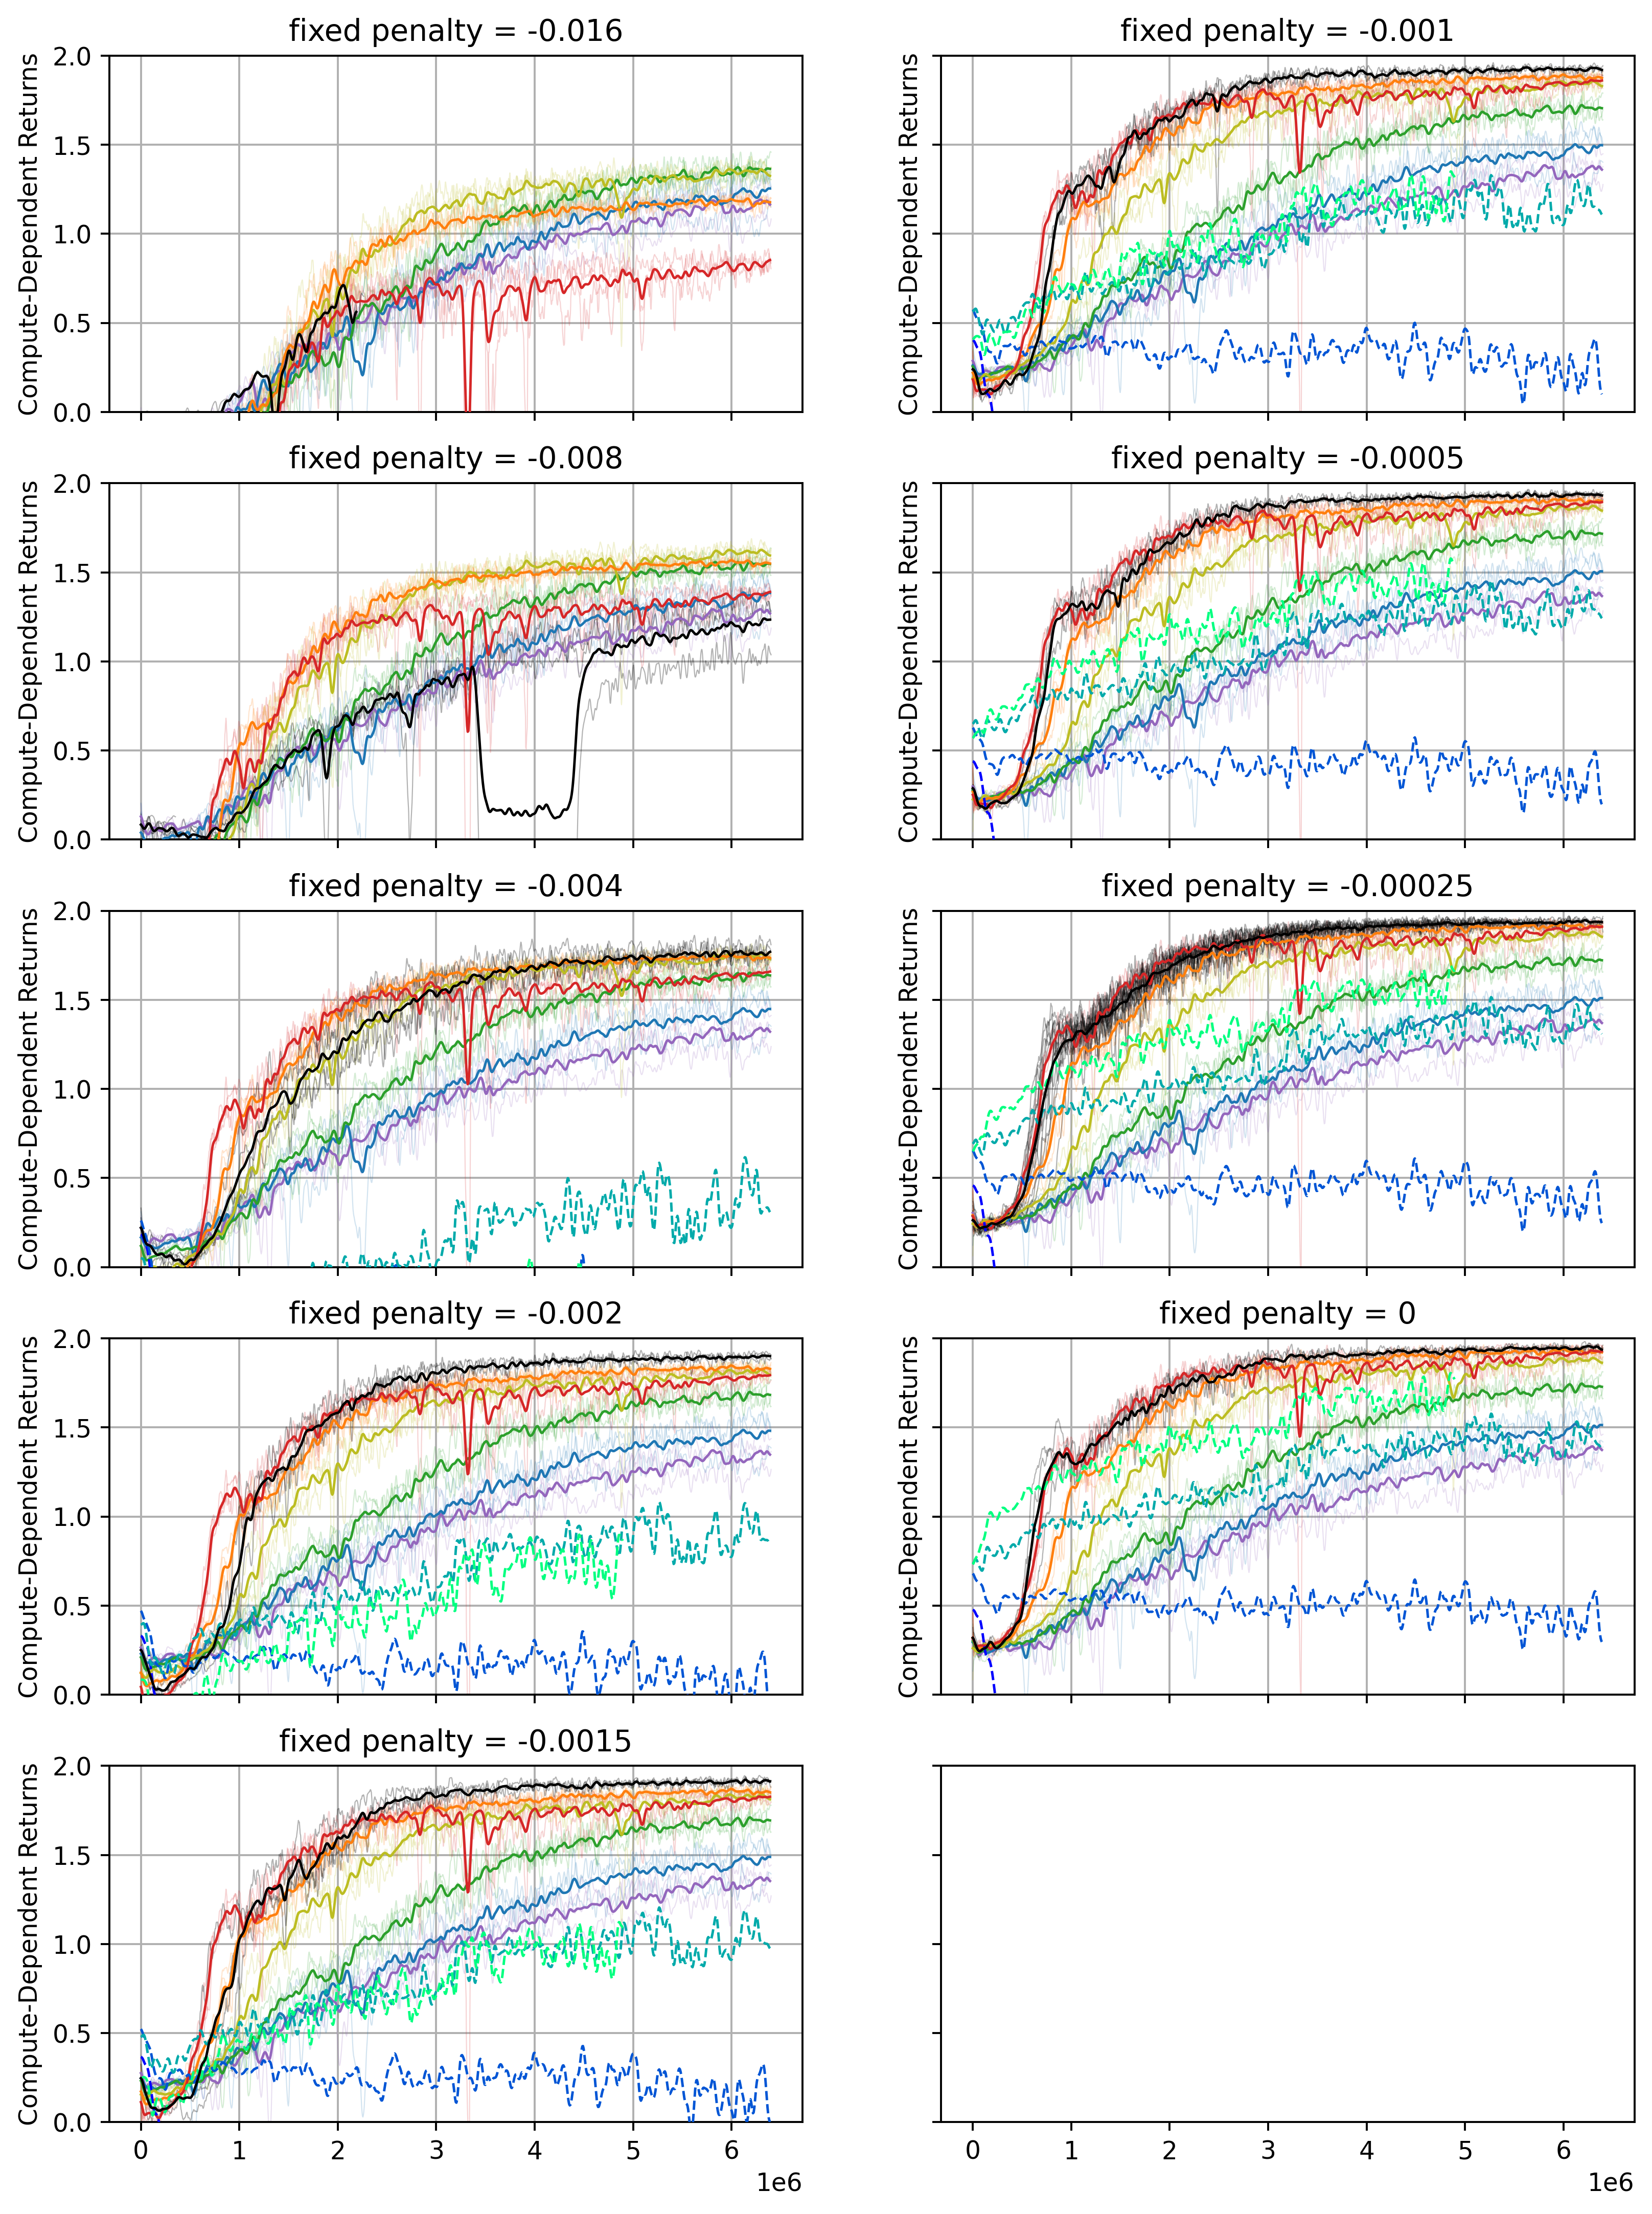

In [4]:
def diff_configs(df, label):
    OK = ['xpid', 'ckpdir', 'cmd', 'savedir']
    configs = defaultdict(set)
    for _, row in df.iterrows():
        config = row['config']
        for k in config:
            configs[k].add(config[k])
    for k in configs:
        if len(configs[k]) > 1 and k not in OK:
            print(f'{label}\t- Rows have different values for `{k}`: {configs[k]}')

class Plotter:
    def __init__(self, project_ids, env_name, config_constraints=None):
        """e.g. kevin-team/thinker-flexible-k
        e.g. knapsack-20x9-v0
        config_constraints: {'total_steps': 6400000}
        """
        if type(project_ids) != type([]):
            raise ValueError('project_ids should be a lixst')
        self.project_id = project_ids
        self.env_name = env_name
        self.config_constraints = {} if config_constraints is None else config_constraints
        
        self.runs = []
        for project_id in project_ids:
            self.runs += api.runs(project_id, )
        self.get_runs()
    @property
    def human_readable_name(self):
        return human_readable_env_names[self.env_name]
    def get_runs(self):
        summary_list, config_list, name_list, path_list = [], [], [], []
        for run in self.runs: 
#             print(dir(run))
#             print(run.user, run.path, run.project, run.entity)
            if run.config['name'] != self.env_name:
                continue
            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files 
            summary_list.append(run.summary._json_dict)

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config_list.append(
                {k: v for k,v in run.config.items()
                  if not k.startswith('_')})

            # .name is the human-readable name of the run.
            name_list.append(run.name)
            path_list.append('/'.join(run.path))
            

        runs_df = pd.DataFrame({
            "summary": summary_list,
            "config": config_list,
            "name": name_list,
            "path": path_list,
            })
        def config_check(x):
            for k, v in self.config_constraints.items():
                if type(v) is list:
                    if x[k] not in v:
                        return False
                else:
                    if x[k] != v:
                        return False
            return True
        self.flexible_k_runs = runs_df[runs_df['config'].apply(lambda x: x['flexible_k'] and config_check(x))]
        self.mcts_runs = runs_df[runs_df['config'].apply(lambda x: x['mcts'] and config_check(x))]
        self.fixed_k_runs = runs_df[runs_df['config'].apply(lambda x: not x['flexible_k'] and not x['mcts'] and not x['wrapper_type']==1 and config_check(x))]
        self.model_free_rl_runs = runs_df[runs_df['config'].apply(lambda x: x['wrapper_type']==1 and config_check(x))]


        diff_configs(self.flexible_k_runs, 'flexible k')
        diff_configs(self.mcts_runs, 'mcts')
        diff_configs(self.fixed_k_runs, 'fixed k')
        diff_configs(self.model_free_rl_runs, 'model free rl')

        
    def plot_adj_returns(self, x_label, x_to, ylim_min=-0.5, ylim_max=3, penalties=None, plot=True): #, x_from, x_to):
        flexible_k_runs, mcts_runs, fixed_k_runs, model_free_rl_runs = self.flexible_k_runs, self.mcts_runs, self.fixed_k_runs, self.model_free_rl_runs
        just_one = penalties is not None and len(penalties)==1
        if penalties is not None:
            flexible_k_runs = flexible_k_runs[flexible_k_runs['config'].apply(lambda x: x['fixed_step_cost'] in penalties)]
        mcts_ks = defaultdict(lambda : {'constituents': [], 'avg': {}})
        fixed_ks = defaultdict(lambda : {'constituents': [], 'avg': {}})
        flexible_ks = defaultdict(lambda: {'constituents': [], 'avg': {}})
        
        for _, run in tqdm(fixed_k_runs.iterrows()):
            # print(run['name'])
            rec_t = run['config']['rec_t']
            history = cached_history(run['path'], 3500)
            try:
                fixed_ks[rec_t]['constituents'].append({
                    'xs': history[x_label],
                    'rmean_episode_return': history['rmean_episode_return'],
                    'rmean_episode_steps': history['rmean_episode_steps']
                })
            except KeyError:
                continue
        for _, run in tqdm(mcts_runs.iterrows()):
            # print(run['name'])
            rec_t = run['config']['rec_t']
            history = cached_history(run['path'], 3500)
            try:
                if 'rmean_episode_steps' not in history:
                    print('approximating rmean_episode_steps')
                    rmean_episode_steps = (history['rmean_adj_episode_return'] - history['rmean_episode_return']) / run['config']['fixed_step_cost']
                else:
                    rmean_episode_steps = history['rmean_episode_steps']
                mcts_ks[rec_t]['constituents'].append({
                    'xs': history[x_label],
                    'rmean_episode_return': history['rmean_episode_return'],
                    'rmean_adj_episode_return': history['rmean_adj_episode_return'],
                    'rmean_episode_steps': rmean_episode_steps,
                })
                
            except KeyError as e:
                print(run['config']['rec_t'])
                print(e)
                continue
        for _, run in tqdm(flexible_k_runs.iterrows()):
            penalty = run['config']['fixed_step_cost']
            history = cached_history(run['path'], 3500)
            try:
                flexible_ks[penalty]['constituents'].append({
                    'xs': history[x_label],
                    'rmean_adj_episode_return': history['rmean_adj_episode_return'],
                    'rmean_episode_return': history['rmean_episode_return'],
                    'rmean_episode_steps': history['rmean_episode_steps'],
                    'rmean_episode_real_steps': history['rmean_episode_real_steps'],
                })
            except KeyError:
                continue
        common_time = np.linspace(0, x_to, 1000)
        for runs_type, runs in ('fixed', fixed_ks), ('flexible', flexible_ks), ('mcts', mcts_ks):
            # cmap = plt.cm.viridis
            if runs_type == 'fixed':
                cmap = LinearSegmentedColormap.from_list('', ['C4', 'C0', 'C2', 'C8', 'C1', 'C3'])
                norm = BoundaryNorm(np.arange(-0.5, len(runs) + 0.5, 1), cmap.N)
            elif runs_type == 'mcts':
                cmap = plt.cm.winter
                norm = BoundaryNorm(np.arange(-0.5, len(runs) + 0.5, 1), cmap.N)
            for i, k in enumerate(sorted(runs.keys())):
                if runs_type=='fixed':
                    runs[k]['color'] = cmap(norm(i))
                    runs[k]['linestyle'] = 'solid'
                elif runs_type=='mcts':
                    runs[k]['color'] = cmap(norm(i))
                    runs[k]['linestyle'] = 'dashed'
                interpolated_values = defaultdict(list)
                if len(runs.values()) == 0 or len(list(runs.values())[0]['constituents'])==0:
                    continue
                for y_label in list(runs.values())[0]['constituents'][0].keys():
                    if y_label=='xs':
                        continue
                    for run in runs[k]['constituents']:
                        interpolated_values[y_label].append(np.interp(common_time, run['xs'], run[y_label], right=np.nan))
                    if len(interpolated_values[y_label]) == 0:
                        print(f"no values for {k}: {y_label}")
                        runs[k]['avg'][y_label] = np.full(1000, np.nan)
                        continue
                        
                    average_values = np.nanmean(interpolated_values[y_label], axis=0)
                    
                    runs[k]['avg'][y_label] = average_values
                        
                runs[k]['avg']['xs'] = common_time
        
        table_data = dict()
        def table_init_flex(fixed_step_cost):
            table_data[fixed_step_cost] = {'flex': None, 'fixed': [], 'model-free': None, 'mcts': []}
        def table_set_flex(fixed_step_cost, steps, v, uncertainty):
            table_data[fixed_step_cost]['flex'] = (steps, v, uncertainty)
        def table_add(exp_type, fixed_step_cost, k, v, uncertainty):
            table_data[fixed_step_cost][exp_type].append((k, v, uncertainty))
            
            
        
        ROWS, COLS = 5, 2
        FIGSIZE = (11, 15)
        if just_one:
            ROWS, COLS = 1, 1
            FIGSIZE = (7.5, 2.6)
        fig, axs = plt.subplots(ROWS, COLS, sharex=True, sharey=True, figsize=FIGSIZE)
        fig.set_dpi(350)
        sm = lambda x, sigma: gaussian_filter1d(x, sigma=sigma) # SMOOTH
        for i, fixed_step_cost in enumerate(sorted(flexible_ks.keys())):
            table_init_flex(fixed_step_cost)
            if i >= ROWS * COLS:
                break
            row, col = i//ROWS, i%ROWS
            if just_one:
                subplot = axs
            else:
                subplot = axs[col][row]
            subplot.grid()
            adj = lambda r: r['rmean_episode_return'] + r['rmean_episode_steps'] * fixed_step_cost
            for exp_type, ks in [('fixed', fixed_ks), ('mcts', mcts_ks)]:
                for k, v in ks.items():
                    if len(v['constituents']) == 0:
                        continue
                    for constituent in v['constituents']:
                        if exp_type == 'mcts':
                            continue
                        subplot.plot(constituent['xs'], sm(adj(constituent),1.3), linewidth=0.45, alpha=0.2, color=v['color'])
                    sm_adj_avg = sm(adj(v['avg']),2.8)
                    label = f'Thinker k={k}' if exp_type=='fixed' else f'MCTS k={k}'
                    subplot.plot(v['avg']['xs'], sm_adj_avg, linewidth=1.0, alpha=1, color=v['color'], zorder=7, label=label, linestyle=v['linestyle'])
                    table_add(exp_type, fixed_step_cost, k, sm_adj_avg[-1], 0)
                
            
            flexible_k = flexible_ks[fixed_step_cost]
            for constituent in flexible_k['constituents']:
                subplot.plot(constituent['xs'], sm(adj(constituent),1.3), linewidth=0.45, alpha=0.3, color='black')
            # axs[col][row].plot(flexible_k['avg']['xs'], flexible_k['avg']['rmean_adj_episode_return'], color='black') # sanity check, should match below
            sm_adj_avg = sm(adj(flexible_k['avg']),2.8)
            subplot.plot(flexible_k['avg']['xs'], sm_adj_avg, linewidth=1.0, color='black', zorder=8, label="Dynamic Thinker (Ours)") # sanity check, should match above
            avg_search_steps = sm(flexible_k['avg']['rmean_episode_steps'] / flexible_k['avg']['rmean_episode_real_steps'], 2.8)[-1]
            table_set_flex(fixed_step_cost, avg_search_steps, sm_adj_avg[-1], 0)
            subplot.set_ylim(ylim_min, ylim_max)
            subplot.set_ylabel(TIMED_RETURNS_NAME)
            if just_one:
                subplot.set_xlabel("Real Training Steps")
                subplot.legend(fontsize='7', facecolor='white', framealpha=1)
            else:
                subplot.set_title(f'fixed penalty = {fixed_step_cost}')
        if plot:
            fig.show()
        else:
            fig.clf()
        return table_data
        
        

    def plot_pareto(self, x_label, x_from, x_to, plot_title: str, avg_fn, x_val_type: str, plot_mcts: bool, plot_model_free_rl: bool,
             plot_scatter=True, plot_line_fixed=True, plot_line_flexible=True, plot_avg=None,
             plot_rectangles=True, use_title=True, plot=True, deprecated_xval=False):
        plt.figure(figsize=(4.5,3))
        flexible_k_runs, mcts_runs, fixed_k_runs, model_free_rl_runs = self.flexible_k_runs, self.mcts_runs, self.fixed_k_runs, self.model_free_rl_runs
        if plot_avg is None:
            plot_avg = not plot_scatter and not plot_line_flexible
        lw_fixed = 2 if plot_line_fixed else 0
        lw_flexible = 2 if plot_line_flexible else 0
        D_LABEL = 'Dynamic Thinker (Ours)'
        
        def get_num_steps_per_episode(run, y1, y2):
            return (y1-y2) / -run['config']['fixed_step_cost']
        def get_num_steps_per_real_step(run, _, __):
            if run['config']['flexible_k']:
                try:
                    num_all_steps = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_episode_steps')
                    num_real_steps = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_episode_real_steps')
                    r = num_all_steps / num_real_steps
                    if pd.isna(r):
                        raise ValueError
                    return r
                except ValueError:
                    if deprecated_xval:
                        print("TEMPORARY HACK! mean_stage_length is subtly NOT the mean stage length.")
                        # It should be the mean over each stage, sampled uniformly, not amongst a batch (where long stages are oversampled)
                        return get_avg_value(run['path'], x_label, x_from, x_to, 'mean_stage_length')
                    else:
                        return pd.NA
            else:
                return run['config']['rec_t']
        def uncertainty_fn(_ys):
            return np.std(_ys)

        if x_val_type == 'steps_per_episode':
            x_val_fn = get_num_steps_per_episode
        elif x_val_type == 'steps_per_real_step':
            x_val_fn = get_num_steps_per_real_step
        else:
            raise ValueError(f'unrecognized x_val_type {x_val_type}')
            
        table_data = []
        def add_to_table(ex_type, key, search, returns, uncer):
            table_data.append({'ex_type': ex_type, 'key': key, 'search': search, 'returns': returns, 'uncer': uncer})

        # FLEXIBLE K
        mean_search_used = defaultdict(list)
        mean_untimed_rewards = defaultdict(list)
        for _, run in tqdm(flexible_k_runs.iterrows()):
            time_penalty = run['config']['fixed_step_cost']
            y1 = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_episode_return')
            y2 = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_adj_episode_return')
            if pd.isna(y1) or pd.isna(y2):
                continue
            x_val = x_val_fn(run, y1, y2)
            if pd.isna(x_val):
                continue
            mean_search_used[time_penalty].append(x_val)
            mean_untimed_rewards[time_penalty].append(y1)

        xs, ys, y_uncers = [], [], []
        cmap = plt.cm.viridis
        norm = BoundaryNorm(np.arange(-0.5, len(mean_search_used) + 0.5, 1), cmap.N)

        for i, key in enumerate(sorted(mean_search_used.keys())):
            _xs, _ys = mean_search_used[key], mean_untimed_rewards[key]
            if len(_xs) < 3:
                print(f'{key} has less than 3 runs (only {len(_xs)})')
            if plot_rectangles:
                plt.fill_between([min(_xs) - .1, max(_xs) + .1], min(_ys), max(_ys), alpha=0.2)
            if plot_scatter:
                plt.scatter([x for x in _xs], _ys, marker='*', color=cmap(norm(i)), zorder=3, s=42, label=D_LABEL)
            x = avg_fn(_xs)
            y = avg_fn(_ys)
            y_uncer = uncertainty_fn(_ys)
            print(f'flex {key}: search {x:.1f}, performance {y:.3f}, n={len(_xs)}')
            xs.append(x)
            ys.append(y)
            add_to_table(ex_type='flexible', key=key, search=x, returns=y, uncer=y_uncer)
        
        marker = '*' if plot_avg else None
        plt.plot(xs, ys, marker=marker, markersize=7, lw=lw_flexible, zorder=1)
        
        sc = plt.scatter([], [], c=[], cmap=cmap, norm=norm)  # Dummy scatter for colorbar
        cbar = plt.colorbar(sc, ticks=np.arange(len(mean_search_used)), shrink=0.75)
        cbar.set_ticklabels([-x for x in (sorted(mean_search_used.keys()))])  # Custom labels
#         cbar.set_label('Compute Penalty', size=7)
        cbar.ax.set_title('             Compute Penalty', size=6)
        cbar.ax.tick_params(labelsize=7) 

        # FIXED K
        mean_search_used = defaultdict(list)
        mean_untimed_rewards = defaultdict(list)
        for _, run in tqdm(fixed_k_runs.iterrows()):
            # print(run['name'])
            rec_t = run['config']['rec_t']
            time_penalty = run['config']['fixed_step_cost']
            y1 = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_episode_return')
            y2 = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_adj_episode_return')
            if pd.isna(y1) or pd.isna(y2):
                continue
            mean_search_used[rec_t].append(x_val_fn(run, y1, y2))
            mean_untimed_rewards[rec_t].append(y1)

        xs, ys, y_uncers = [], [], []
        for i, key in enumerate(sorted(mean_search_used.keys(), reverse=True)):
            _xs, _ys = mean_search_used[key], mean_untimed_rewards[key]
            if len(_xs) < 3:
                print(f'{key} has less than 3 runs (only {len(_xs)})')
            if plot_rectangles:
                plt.fill_between([min(_xs) - .1, max(_xs) + .1], min(_ys), max(_ys), alpha=0.2)
            if plot_scatter:
                # color = ((255 - 18*i)/255, (135 - 10*i)/255, (20 - 3*i)/255)
                plt.scatter([x for x in _xs], _ys, color='C1', zorder=2, alpha=0.81, s=13)
            xs.append(avg_fn(_xs))
            ys.append(avg_fn(_ys))
            y_uncer = uncertainty_fn(_ys)
#             y_uncers.append()
            add_to_table(ex_type='fixed', key=key, search=x, returns=y, uncer=y_uncer)


        marker = 'o' if plot_avg else None
        plt.plot(xs, ys, label='Thinker', marker=marker, lw=lw_fixed, zorder=1)
        
        # MODEL-FREE RL
        if plot_model_free_rl:
            mean_untimed_rewards = []
            for _, run in tqdm(model_free_rl_runs.iterrows()):
                y1 = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_episode_return')
                if pd.isna(y1):
                    continue
                mean_untimed_rewards.append(y1)

            if len(mean_untimed_rewards) > 0:
                _ys = mean_untimed_rewards
                _xs = [1 for _ in _ys]

                if len(_xs) < 3:
                    print(f'Model-Free RL has less than 3 runs (only {len(_xs)})')
                if plot_rectangles:
                    plt.fill_between([min(_xs) - .1, max(_xs) + .1], min(_ys), max(_ys), alpha=0.2)
                if plot_scatter:
                    # color = ((255 - 18*i)/255, (135 - 10*i)/255, (20 - 3*i)/255)
                    plt.scatter([x for x in _xs], _ys, color='C3', zorder=2, alpha=0.81, label='Model-Free RL')
                xs = avg_fn(_xs)
                ys = avg_fn(_ys)

#                 marker = 'o' if plot_avg else None
#                 plt.plot(xs, ys, label='Model-Free RL', marker=marker, lw=lw_fixed, zorder=1)

        # MCTS
        if plot_mcts:
            mean_search_used = defaultdict(list)
            mean_untimed_rewards = defaultdict(list)
            for _, run in mcts_runs.iterrows():
                rec_t = run['config']['rec_t']
                y1 = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_episode_return')
                y2 = get_avg_value(run['path'], x_label, x_from, x_to, 'rmean_adj_episode_return')
                if pd.isna(y1) or pd.isna(y2):
                    continue
                mean_search_used[rec_t].append(x_val_fn(run, y1, y2))
                mean_untimed_rewards[rec_t].append(y1)

            xs, ys = [], []
            for key in sorted(mean_search_used.keys()):
                _xs, _ys = mean_search_used[key], mean_untimed_rewards[key]
                if len(_xs) < 3:
                    print(f'{key} has less than 3 runs (only {len(_xs)})')
                if plot_rectangles:
                    plt.fill_between([min(_xs) - .1, max(_xs) + .1], min(_ys), max(_ys), alpha=0.2)
                if plot_scatter:
                    plt.scatter([x for x in _xs], _ys, color='C2')
                x = avg_fn(_xs)
                y = avg_fn(_ys)
                xs.append(x)
                ys.append(y)
            marker = 'o' if plot_avg else None
            plt.plot(xs, ys, marker=marker, label='AlphaZero (MCTS)', lw=2)

        # PLOT
        plt.ylabel('Raw Returns')
        if x_val_type == 'steps_per_episode':
            plt.xlabel('Total Planning Steps per Episode') # Total Steps per Episode (Incl. Planning Steps)
        elif x_val_type == 'steps_per_real_step':
            plt.xlabel('Compute (Planning Length per Step)')
            # plt.xlabel('Total Planning Steps per Step')
        else:
            raise ValueError(f"unknown {x_val_type=}")
        # plt.ylim(0.91, 1.)
        plt.grid()
        plt.minorticks_on()  # Enable minor ticks
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

        handles, labels = plt.gca().get_legend_handles_labels()
        dynamic_thinker_handles = []
        other_handles = []
        other_labels = []
        for i, (handle, label) in enumerate(zip(handles, labels)):
            
#                 new_handle = copy.copy(handle)
#                 new_handle.set_marker('*')
#                 handles[i] = new_handle
            new_handle = copy.copy(handle)
            if label == 'Thinker':
                new_handle.set_marker('o')
                new_handle.set_alpha(0.81)
                # handles[i] = new_handle
            if label == D_LABEL:
                dynamic_thinker_handles.append(new_handle)
            else:
                other_handles.append(new_handle)
                other_labels.append(label)
        other_handles.append(tuple(dynamic_thinker_handles))
        other_labels.append(D_LABEL)
        plt.legend(handles=other_handles, labels=other_labels, facecolor='white', framealpha=0.8, handler_map={tuple: HandlerTuple(ndivide=None)})
        if use_title:
            plt.title(TITLE)
        fig = plt.gcf()
        fig.set_dpi(250)
        if not plot:
            plt.cla()

            
# knapsack = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-v2')
# subset_sum = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-v0')
knapsack_bonus = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-bonus-v3', config_constraints={
                            'fixed_step_cost': [-0.016, -0.00025, -0.001, -0.0015, -0.002, -0.0005, 0, -0.004, -0.008]
                        })

knapsack_bonus.plot_adj_returns('_step', x_to=6390000, ylim_min=0, ylim_max=2)
# knapsack.plot_adj_returns('_step', x_to=6380000, ylim_min=0, ylim_max=1)
# subset_sum.plot_adj_returns('_step', x_to=6380000, ylim_min=0.6, ylim_max=1)
# subset_sum.plot_adj_returns('_step', x_to=6380000, ylim_min=0.6, ylim_max=1, penalties=[-0.0015])

# X_LABEL = '_step'
# X_FROM, X_TO = 6300000, 6400000
# TITLE = f"{human_readable_env_names[knapsack.env_name]} Returns after Training for 6.4M Real Steps"

# knapsack.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
#                      plot_mcts=False, plot_model_free_rl=False, plot_rectangles=False,
#                      plot_line_flexible=False, use_title=False)

In [5]:
subset_sum = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-v0')

flexible k	- Rows have different values for `ckp`: {False, True}
flexible k	- Rows have different values for `ray_cpu`: {9, 18, 20, 14}
flexible k	- Rows have different values for `total_steps`: {5000000, 6400000}
flexible k	- Rows have different values for `git_revision`: {'b1a32d8f3b3348e41bef8eb4776448d43992f819', 'b9f64524ab38e62f37323319f7fa20cac0ab4e52', '4df5bd21ffbea9346b744a619f44636225579c33', '238587a557fa3f86613e31dc270e8546f2fa8187', '6766193c057e60dd517f1e573a40fe784bcd3cc9'}
flexible k	- Rows have different values for `fixed_step_cost`: {0, -0.0005, -0.001, -0.0015, -0.00025, -0.000125, -0.0001}
flexible k	- Rows have different values for `model_warm_up_n`: {50001, 10001}
mcts	- Rows have different values for `env_n`: {64, 256}
mcts	- Rows have different values for `rec_t`: {100, 5, 12, 50, 25}
mcts	- Rows have different values for `ray_cpu`: {16, 11, 20}
mcts	- Rows have different values for `total_steps`: {64000000, 6400000}
mcts	- Rows have different values for `git_r

In [6]:
subset_sum_bonus = Plotter(['kevin-team/thinker-flexible-k'], 'subset-sum-20x9-bonus-v0')

flexible k	- Rows have different values for `ray_cpu`: {8, 9, 11}
flexible k	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}
flexible k	- Rows have different values for `fixed_step_cost`: {0, -0.0005, -0.001, -0.0015, -0.00025, -0.002, -0.0001, -0.004, -0.008, 0.0005}
flexible k	- Rows have different values for `model_warm_up_n`: {50001, 10001}
mcts	- Rows have different values for `rec_t`: {100, 25, 50, 12}
mcts	- Rows have different values for `ray_cpu`: {12, 14}
mcts	- Rows have different values for `buffer_traj_len`: {50, 20}
fixed k	- Rows have different values for `rec_t`: {3, 4, 6, 9, 13, 19}
fixed k	- Rows have different values for `ray_cpu`: {8, 9}
model free rl	- Rows have different values for `ray_cpu`: {11, 14}
model free rl	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}


In [7]:
knapsack = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-v2')

flexible k	- Rows have different values for `ckp`: {False, True}
flexible k	- Rows have different values for `ray_cpu`: {10, 9, 18, 11}
flexible k	- Rows have different values for `git_revision`: {'b1a32d8f3b3348e41bef8eb4776448d43992f819', '4df5bd21ffbea9346b744a619f44636225579c33', 'b08e57af1a1b272f744d513dacc041826ce31eab', '238587a557fa3f86613e31dc270e8546f2fa8187', '6766193c057e60dd517f1e573a40fe784bcd3cc9'}
flexible k	- Rows have different values for `fixed_step_cost`: {0, -0.0005, -0.001, -0.0015, -0.00025, -0.002, -0.0001}
flexible k	- Rows have different values for `model_warm_up_n`: {50001, 10001}
mcts	- Rows have different values for `rec_t`: {25, 50, 12}
mcts	- Rows have different values for `ray_cpu`: {12, 14}
mcts	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}
mcts	- Rows have different values for `buffer_traj_len`: {50, 20}
fixed k	- Rows have different values for `ckp`: {False, Tr

In [8]:
knapsack_bonus = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-bonus-v3',
                        config_constraints={
                            'fixed_step_cost': [-0.016, -0.00025, -0.001, -0.0015, -0.002, -0.0005, 0, -0.004, -0.008]
                        })

flexible k	- Rows have different values for `ray_cpu`: {8, 10}
flexible k	- Rows have different values for `fixed_step_cost`: {-0.016, -0.00025, -0.001, -0.0015, -0.002, -0.0005, 0, -0.004, -0.008}
mcts	- Rows have different values for `rec_t`: {100, 25, 50, 12}
mcts	- Rows have different values for `ray_cpu`: {12, 14}
mcts	- Rows have different values for `buffer_traj_len`: {50, 20}
fixed k	- Rows have different values for `rec_t`: {3, 4, 6, 9, 13, 19}
model free rl	- Rows have different values for `ray_cpu`: {11, 14}
model free rl	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}


In [9]:
knapsack_bonus2 = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-bonus2-v3',
                          config_constraints={
                              'wrapper_type': [1,2], 
                              # don't use -0.016 and 0.0005 because we didn't use these for the other envs?
                              # they don't perform great, although not substantially worse than others
                              # tightens up the graph, makes colors consistent
                              'fixed_step_cost': [-0.0005, -0.001, -0.0015, -0.002, -0.00025, 0, -0.0001, -0.004, -0.008],
                          })

flexible k	- Rows have different values for `ray_cpu`: {9, 10}
flexible k	- Rows have different values for `fixed_step_cost`: {0, -0.0005, -0.001, -0.0015, -0.002, -0.00025, -0.0001, -0.004, -0.008}
mcts	- Rows have different values for `rec_t`: {100, 25, 50, 12}
fixed k	- Rows have different values for `rec_t`: {3, 4, 6, 9, 13, 19}
model free rl	- Rows have different values for `ray_cpu`: {11, 14}
model free rl	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}


In [10]:
knapsack_bonus2_lm = Plotter(['kevin-team/thinker-flexible-k'], 'knapsack-20x9-bonus2-v3',
                          config_constraints={'wrapper_type': 0})

flexible k	- Rows have different values for `ray_cpu`: {8, 10, 11, 12, 14}
flexible k	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}
flexible k	- Rows have different values for `fixed_step_cost`: {0, -0.0005, -0.001, -0.0015, -0.002, -0.00025, -0.0001, -0.004}
flexible k	- Rows have different values for `model_warm_up_n`: {50001, 10001}
fixed k	- Rows have different values for `rec_t`: {3, 4, 6, 9, 13, 19}
fixed k	- Rows have different values for `ray_cpu`: {8, 10, 11, 12, 14}
fixed k	- Rows have different values for `git_revision`: {'6766193c057e60dd517f1e573a40fe784bcd3cc9', 'b08e57af1a1b272f744d513dacc041826ce31eab'}
fixed k	- Rows have different values for `model_warm_up_n`: {50001, 10001}


In [11]:
sokoban = Plotter(['kevin-team/fixed-sokoban', 'kevin-team/sokoban-stat', 'kevin-team/sokoban-exp'], 'Sokoban-v0',
                 config_constraints={
                     'rec_t': [2, 5, 10, 20, 30],
                     'max_depth': [5, 6, 30],
                 })

flexible k	- Rows have different values for `rec_t`: {20, 30}
flexible k	- Rows have different values for `project`: {'fixed-sokoban', 'sokoban-stat', 'sokoban-exp'}
flexible k	- Rows have different values for `ray_cpu`: {16, 20, 12}
flexible k	- Rows have different values for `max_depth`: {5, 6, 30}
flexible k	- Rows have different values for `total_steps`: {50000000, 40000000}
flexible k	- Rows have different values for `git_revision`: {'ed80ae81764b937520404e6b7cf4e8d97e99f54d', 'ac67224e35c20130d6b1090c669984dfa97647cb', '074617365a9ada556a1be6468c35243ca398eea1', 'd1783824314a72882a8075f74debfce5178ae656', '6766193c057e60dd517f1e573a40fe784bcd3cc9'}
flexible k	- Rows have different values for `buffer_traj_len`: {100, 50, 80, 300}
flexible k	- Rows have different values for `fixed_step_cost`: {0, -0.0005, -0.001, -0.002, -0.003, -0.0006, -0.005, 0.0002}
flexible k	- Rows have different values for `actor_unroll_len`: {201, 250, 300}
mcts	- Rows have different values for `rec_t`: {10

In [12]:
def print_table(table):
    r = []
    for fixed_step_cost in sorted(table.keys(), reverse=True):
        dat = table[fixed_step_cost]
        best = max(dat['fixed'], key=lambda x: x[1])
        flex_v = dat['flex'][1]
        if np.isnan(flex_v):
            continue
        flex_s = f'{flex_v:.3f}'
        fixe_s = f'{best[1]:.3f}'
        
        fmt = lambda x: f'\\textbf{{{x}}}' if x==max(flex_s, fixe_s) else x
        r.append(f'{fixed_step_cost} & {fmt(flex_s)} & {fmt(fixe_s)} & {dat["flex"][0]:.1f} & {best[0]} \\\\')
    return '\n\hline\n'.join(r)

s = []
table = subset_sum.plot_adj_returns('_step', x_to=6400000, plot=False)
s.append(print_table(table))
s.append('\hline\n\hline')
s.append('\multicolumn{5}{|c|}{Subset Sum Bonus} \\\\\n\hline')
table = subset_sum_bonus.plot_adj_returns('_step', x_to=6400000, plot=False)
s.append(print_table(table))
s.append('\hline\n\hline')
s.append('\multicolumn{5}{|c|}{Knapsack} \\\\\n\hline')
table = knapsack.plot_adj_returns('_step', x_to=6400000, plot=False)
s.append(print_table(table))
s.append('\hline\n\hline')
s.append('\multicolumn{5}{|c|}{Knapsack Bonus (1)} \\\\\n\hline')
table = knapsack_bonus.plot_adj_returns('_step', x_to=6400000, plot=False)
s.append(print_table(table))
s.append('\hline\n\hline')
s.append('\multicolumn{5}{|c|}{Knapsack Bonus (2)} \\\\\n\hline')
table = knapsack_bonus2.plot_adj_returns('_step', x_to=6400000, plot=False)
s.append(print_table(table))
s.append('\hline')

print('\n'.join(s))

54it [01:19,  1.47s/it]
1it [00:07,  7.47s/it]

approximating rmean_episode_steps



2it [00:08,  3.67s/it]

approximating rmean_episode_steps



3it [00:09,  2.33s/it]

approximating rmean_episode_steps



4it [00:09,  1.71s/it]

approximating rmean_episode_steps



5it [00:10,  1.44s/it]

approximating rmean_episode_steps



6it [00:11,  1.23s/it]

approximating rmean_episode_steps



7it [00:12,  1.12s/it]

approximating rmean_episode_steps



8it [00:13,  1.03s/it]

approximating rmean_episode_steps



9it [00:14,  1.01s/it]

approximating rmean_episode_steps



10it [00:18,  2.01s/it]

approximating rmean_episode_steps



11it [00:24,  3.06s/it]

approximating rmean_episode_steps



12it [00:24,  2.39s/it]

approximating rmean_episode_steps



13it [00:25,  1.93s/it]

approximating rmean_episode_steps



14it [00:26,  1.63s/it]

approximating rmean_episode_steps



15it [00:28,  1.69s/it]

approximating rmean_episode_steps



16it [00:29,  1.50s/it]

approximating rmean_episode_steps



17it [00:30,  1.36s/it]

approximating rmean_episode_steps



18it [00:31,  1.27s/it]

approximating rmean_episode_steps



19it [00:32,  1.15s/it]

approximating rmean_episode_steps



20it [00:33,  1.09s/it]

approximating rmean_episode_steps



21it [00:34,  1.00s/it]

approximating rmean_episode_steps



22it [00:35,  1.01it/s]

approximating rmean_episode_steps



23it [00:36,  1.09it/s]

approximating rmean_episode_steps



24it [00:36,  1.20it/s]

approximating rmean_episode_steps



25it [00:37,  1.23it/s]

approximating rmean_episode_steps



26it [00:40,  1.36s/it]

approximating rmean_episode_steps



27it [00:41,  1.26s/it]

approximating rmean_episode_steps



28it [00:42,  1.18s/it]

approximating rmean_episode_steps



29it [00:42,  1.03s/it]

approximating rmean_episode_steps



30it [00:43,  1.02s/it]

approximating rmean_episode_steps



31it [00:44,  1.05s/it]

approximating rmean_episode_steps



32it [00:45,  1.07it/s]

approximating rmean_episode_steps



33it [00:46,  1.13it/s]

approximating rmean_episode_steps



34it [00:47,  1.10it/s]

approximating rmean_episode_steps



35it [00:48,  1.16it/s]

approximating rmean_episode_steps



36it [00:49,  1.01s/it]

approximating rmean_episode_steps



37it [00:50,  1.05it/s]

approximating rmean_episode_steps



38it [00:51,  1.05s/it]

approximating rmean_episode_steps



39it [00:52,  1.01s/it]

approximating rmean_episode_steps



40it [00:53,  1.06s/it]

approximating rmean_episode_steps



41it [00:54,  1.06s/it]

approximating rmean_episode_steps



42it [00:55,  1.00it/s]

approximating rmean_episode_steps



43it [00:56,  1.07it/s]

approximating rmean_episode_steps



44it [00:56,  1.30it/s]

approximating rmean_episode_steps
5
'rmean_adj_episode_return'


45it [00:57,  1.27s/it]


approximating rmean_episode_steps
5
'rmean_adj_episode_return'


42it [00:48,  1.15s/it]
/var/folders/cr/7bwr934100dbcxzchhysy1m80000gn/T/ipykernel_15108/194522703.py:164: RuntimeWarning: Mean of empty slice
  average_values = np.nanmean(interpolated_values[y_label], axis=0)


no values for -0.000125: rmean_adj_episode_return
no values for -0.000125: rmean_episode_return
no values for -0.000125: rmean_episode_steps
no values for -0.000125: rmean_episode_real_steps


21it [00:18,  1.14it/s]
1it [00:00,  1.52it/s]

approximating rmean_episode_steps



2it [00:01,  1.60it/s]

approximating rmean_episode_steps



3it [00:01,  1.67it/s]

approximating rmean_episode_steps



4it [00:02,  1.63it/s]

approximating rmean_episode_steps



5it [00:03,  1.52it/s]

approximating rmean_episode_steps



6it [00:03,  1.49it/s]

approximating rmean_episode_steps



7it [00:04,  1.52it/s]

approximating rmean_episode_steps



8it [00:05,  1.45it/s]

approximating rmean_episode_steps



9it [00:05,  1.46it/s]

approximating rmean_episode_steps


11it [00:06,  1.60it/s]


approximating rmean_episode_steps
100
'rmean_adj_episode_return'


36it [00:26,  1.34it/s]


no values for -0.008: rmean_adj_episode_return
no values for -0.008: rmean_episode_return
no values for -0.008: rmean_episode_steps
no values for -0.008: rmean_episode_real_steps
no values for -0.002: rmean_adj_episode_return
no values for -0.002: rmean_episode_return
no values for -0.002: rmean_episode_steps
no values for -0.002: rmean_episode_real_steps


43it [00:43,  1.01s/it]
1it [00:00,  1.46it/s]

approximating rmean_episode_steps



2it [00:01,  1.57it/s]

approximating rmean_episode_steps



3it [00:01,  1.68it/s]

approximating rmean_episode_steps



4it [00:02,  1.68it/s]

approximating rmean_episode_steps



5it [00:03,  1.65it/s]

approximating rmean_episode_steps


7it [00:03,  2.02it/s]

approximating rmean_episode_steps
approximating rmean_episode_steps
50
'rmean_adj_episode_return'



8it [00:04,  2.35it/s]

approximating rmean_episode_steps
25
'rmean_adj_episode_return'



9it [00:04,  2.60it/s]

approximating rmean_episode_steps
50
'rmean_adj_episode_return'


10it [00:05,  1.92it/s]
49it [00:49,  1.01s/it]
18it [00:00, 9902.61it/s]
15it [00:00, 2540.77it/s]


approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
approximating rmean_episode_steps
100
'rmean_adj_episode_return'


100it [00:00, 11511.11it/s]
22it [00:19,  1.11it/s]
1it [00:00,  1.56it/s]

approximating rmean_episode_steps



2it [00:01,  1.61it/s]

approximating rmean_episode_steps



3it [00:01,  1.73it/s]

approximating rmean_episode_steps



4it [00:02,  1.47it/s]

approximating rmean_episode_steps



5it [00:03,  1.47it/s]

approximating rmean_episode_steps



6it [00:03,  1.47it/s]

approximating rmean_episode_steps



7it [00:04,  1.40it/s]

approximating rmean_episode_steps



8it [00:05,  1.40it/s]

approximating rmean_episode_steps



9it [00:06,  1.46it/s]

approximating rmean_episode_steps



10it [00:07,  1.32it/s]

approximating rmean_episode_steps



11it [00:07,  1.33it/s]

approximating rmean_episode_steps


12it [00:08,  1.44it/s]


approximating rmean_episode_steps
100
'rmean_adj_episode_return'


27it [00:31,  1.17s/it]


0 & \textbf{0.990} & 0.967 & 19.5 & 13 \\
\hline
-0.0001 & \textbf{0.985} & 0.964 & 17.1 & 13 \\
\hline
-0.00025 & \textbf{0.969} & 0.959 & 11.0 & 13 \\
\hline
-0.0005 & \textbf{0.968} & 0.951 & 6.0 & 13 \\
\hline
-0.001 & \textbf{0.949} & 0.934 & 3.9 & 9 \\
\hline
-0.0015 & \textbf{0.939} & 0.924 & 3.3 & 6 \\
\hline
\hline
\multicolumn{5}{|c|}{Subset Sum Bonus} \\
\hline
0 & 1.971 & \textbf{1.974} & 12.1 & 19 \\
\hline
-0.0001 & 1.960 & \textbf{1.970} & 9.3 & 19 \\
\hline
-0.00025 & 1.959 & \textbf{1.963} & 8.0 & 19 \\
\hline
-0.0005 & \textbf{1.967} & 1.952 & 7.1 & 19 \\
\hline
-0.001 & \textbf{1.955} & 1.930 & 6.9 & 19 \\
\hline
-0.0015 & \textbf{1.909} & 1.908 & 7.7 & 19 \\
\hline
\hline
\multicolumn{5}{|c|}{Knapsack} \\
\hline
0 & \textbf{0.983} & 0.965 & 9.0 & 19 \\
\hline
-0.0001 & \textbf{0.980} & 0.961 & 7.7 & 9 \\
\hline
-0.00025 & \textbf{0.971} & 0.956 & 5.7 & 9 \\
\hline
-0.0005 & \textbf{0.960} & 0.948 & 4.5 & 9 \\
\hline
-0.001 & \textbf{0.954} & 0.932 & 3.4 & 9 \\
\hlin

<Figure size 3850x5250 with 0 Axes>

<Figure size 3850x5250 with 0 Axes>

<Figure size 3850x5250 with 0 Axes>

<Figure size 3850x5250 with 0 Axes>

<Figure size 3850x5250 with 0 Axes>

28it [00:34,  1.23s/it]


flex -0.002: search 9.6, performance 11.709, n=3
flex -0.001: search 9.3, performance 11.928, n=3
flex -0.0006: search 10.3, performance 11.682, n=3
flex -0.0005: search 9.2, performance 11.869, n=8
flex 0: search 7.2, performance 11.987, n=3
flex 0.0002: search 7.5, performance 12.073, n=3


30it [00:33,  1.11s/it]
0it [00:00, ?it/s]


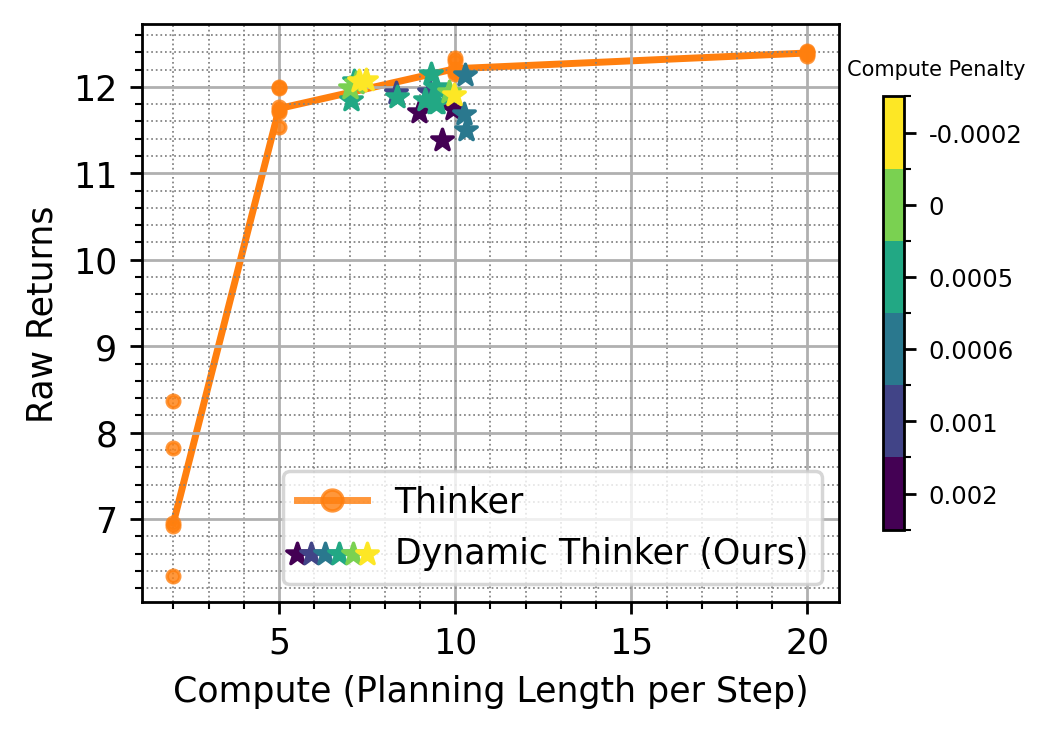

In [13]:
X_LABEL = '_step'
# X_FROM, X_TO = 25000000, 26000000
X_FROM, X_TO = 29000000, 30000000
TITLE = f"{human_readable_env_names[sokoban.env_name]} Returns after Training {X_TO} steps"

sokoban.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                    plot_mcts=False, plot_model_free_rl=True, plot_rectangles=False,
                    plot_avg=False, plot_line_flexible=False, use_title=False)

28it [00:00, 707.09it/s]


-0.001 has less than 3 runs (only 2)
flex -0.001: search 7.4, performance 12.162, n=2
flex -0.0005: search 7.6, performance 12.032, n=6
flex 0: search 6.5, performance 12.164, n=3
flex 0.0002: search 6.8, performance 12.223, n=3


30it [00:00, 1144.16it/s]
0it [00:00, ?it/s]


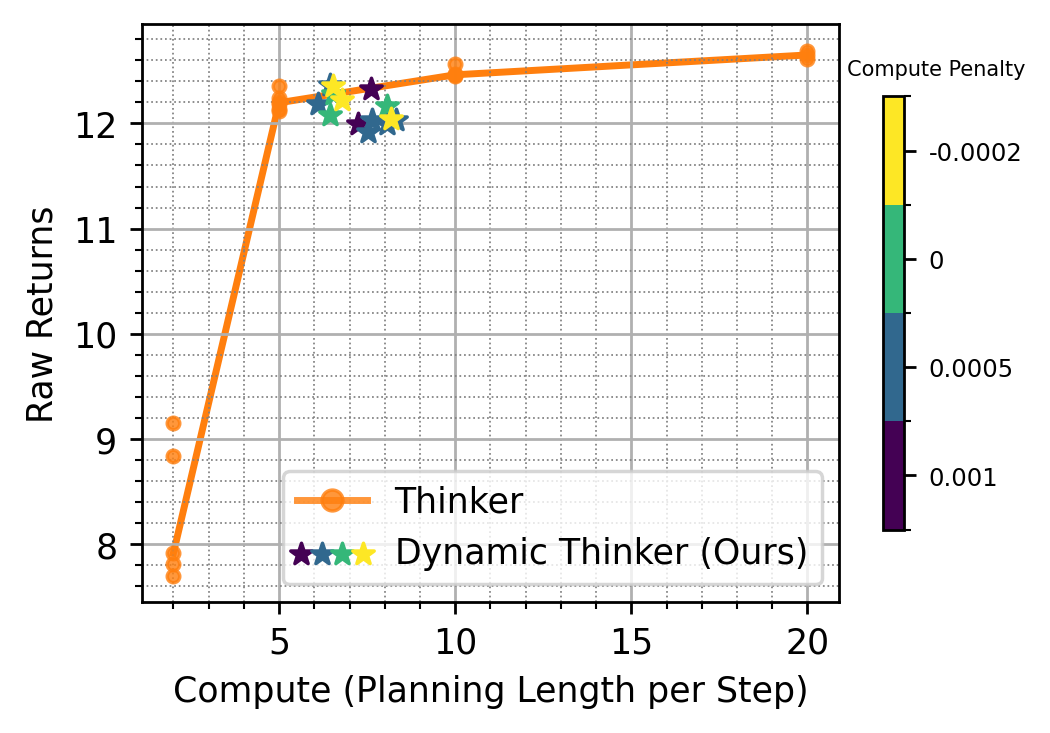

In [14]:
X_LABEL = '_step'
# X_FROM, X_TO = 25000000, 26000000
X_FROM, X_TO = 38000000, 39000000
TITLE = f"{human_readable_env_names[sokoban.env_name]} Returns after Training {X_TO} steps"

sokoban.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                    plot_mcts=False, plot_model_free_rl=True, plot_rectangles=False,
                    plot_avg=False, plot_line_flexible=False, use_title=False)

42it [00:29,  1.41it/s]


flex -0.0015: search 3.3, performance 0.953, n=5
flex -0.001: search 4.0, performance 0.962, n=3
flex -0.0005: search 5.8, performance 0.970, n=3
flex -0.00025: search 9.0, performance 0.979, n=3
flex -0.0001: search 16.6, performance 0.986, n=3
flex 0: search 19.6, performance 0.991, n=3


54it [00:32,  1.66it/s]
42it [00:00, 13925.75it/s]


flex -0.0015: search 3.3, performance 0.953, n=5
flex -0.001: search 4.0, performance 0.962, n=3
flex -0.0005: search 5.8, performance 0.970, n=3
flex -0.00025: search 9.0, performance 0.979, n=3
flex -0.0001: search 16.6, performance 0.986, n=3
flex 0: search 19.6, performance 0.991, n=3


54it [00:00, 17617.64it/s]
3it [00:01,  2.04it/s]


5 has less than 3 runs (only 1)


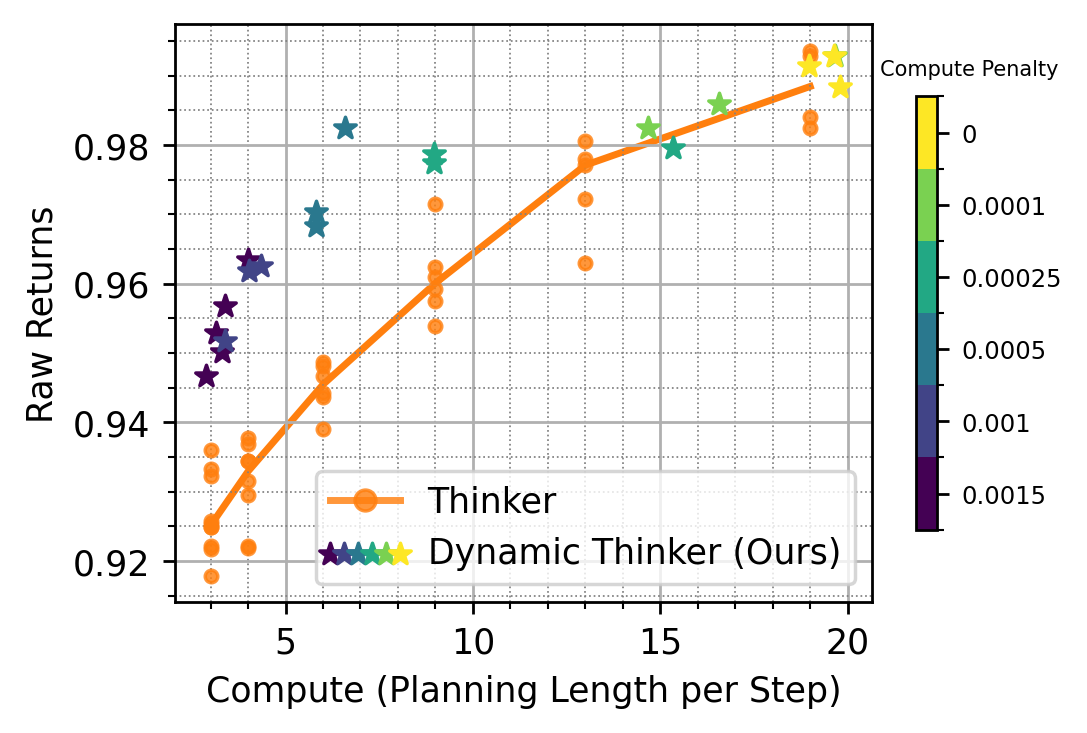

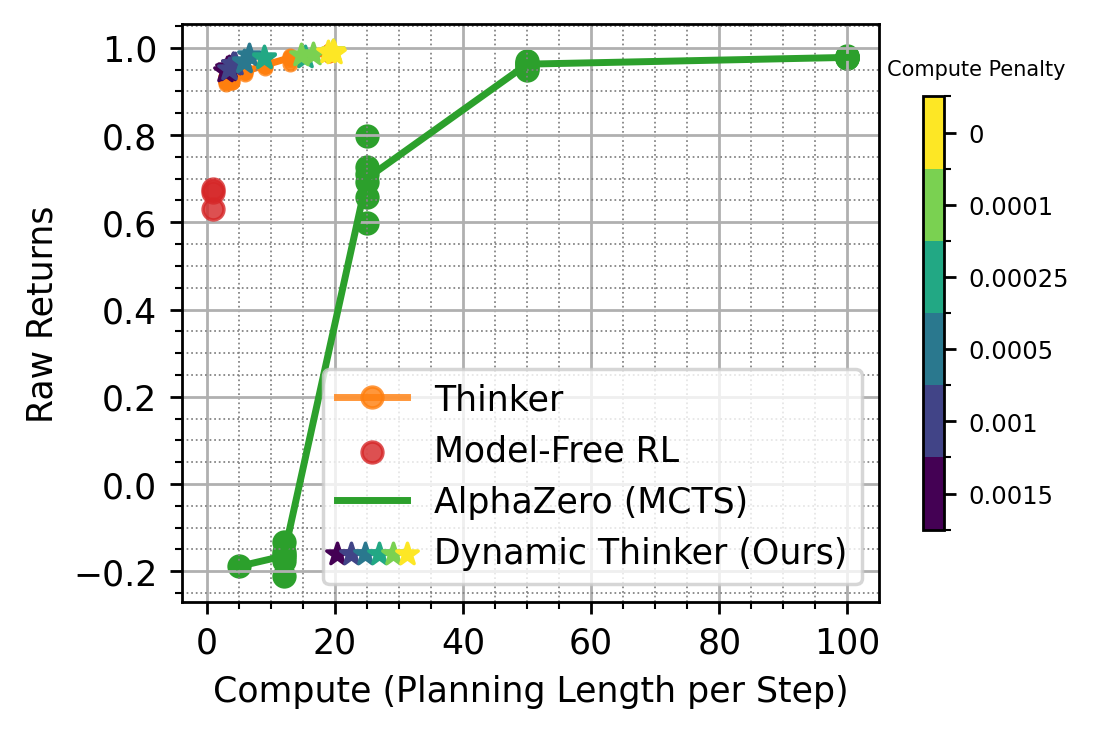

In [15]:
X_LABEL = '_step'
X_FROM, X_TO = 6300000, 6400000
TITLE = f"{human_readable_env_names[subset_sum.env_name]} Returns after Training"
# for 6.4M Real Steps"

subset_sum.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                       plot_mcts=False, plot_model_free_rl=False, plot_rectangles=False,
                       plot_line_flexible=False, plot_avg=False, use_title=False)

subset_sum.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                       plot_mcts=True, plot_model_free_rl=True, plot_rectangles=False,
                       plot_line_flexible=False, plot_avg=False, use_title=False)

36it [00:18,  1.95it/s]


flex -0.0015: search 6.6, performance 1.968, n=3
-0.001 has less than 3 runs (only 2)
flex -0.001: search 7.1, performance 1.970, n=2
flex -0.0005: search 7.3, performance 1.983, n=3
flex -0.00025: search 8.9, performance 1.970, n=3
flex -0.0001: search 9.8, performance 1.964, n=3
flex 0: search 12.0, performance 1.971, n=3


21it [00:11,  1.78it/s]


6 has less than 3 runs (only 2)


36it [00:00, 15857.48it/s]


flex -0.0015: search 6.6, performance 1.968, n=3
-0.001 has less than 3 runs (only 2)
flex -0.001: search 7.1, performance 1.970, n=2
flex -0.0005: search 7.3, performance 1.983, n=3
flex -0.00025: search 8.9, performance 1.970, n=3
flex -0.0001: search 9.8, performance 1.964, n=3
flex 0: search 12.0, performance 1.971, n=3


21it [00:00, 15207.25it/s]


6 has less than 3 runs (only 2)


9it [00:04,  2.14it/s]


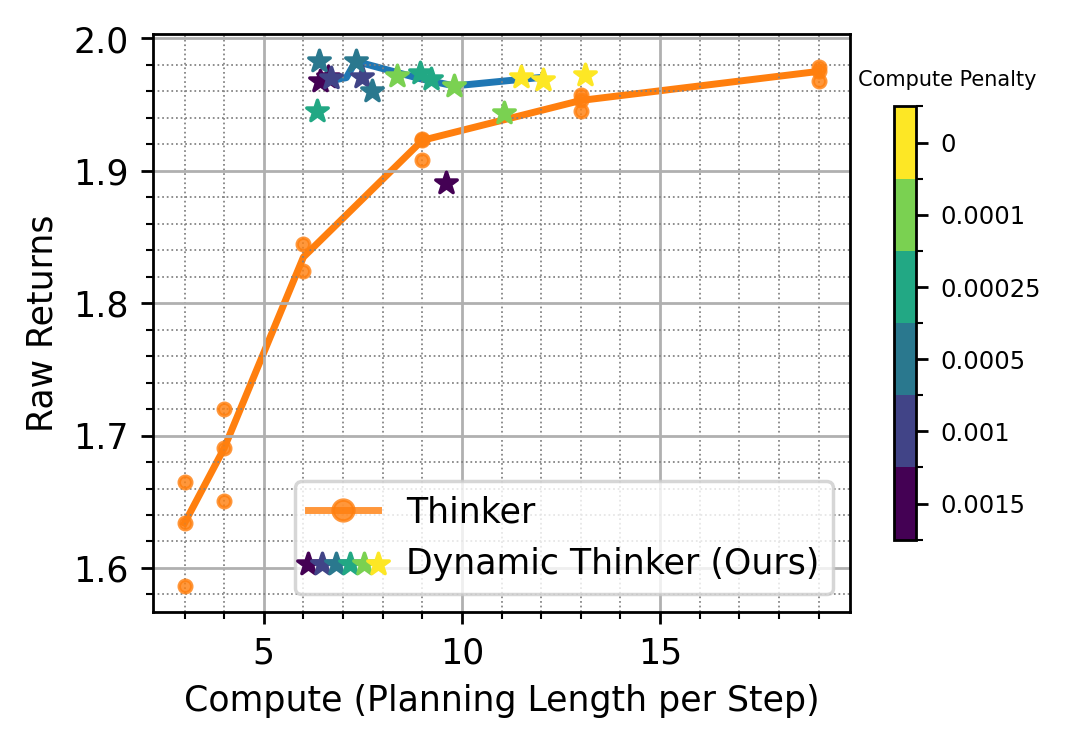

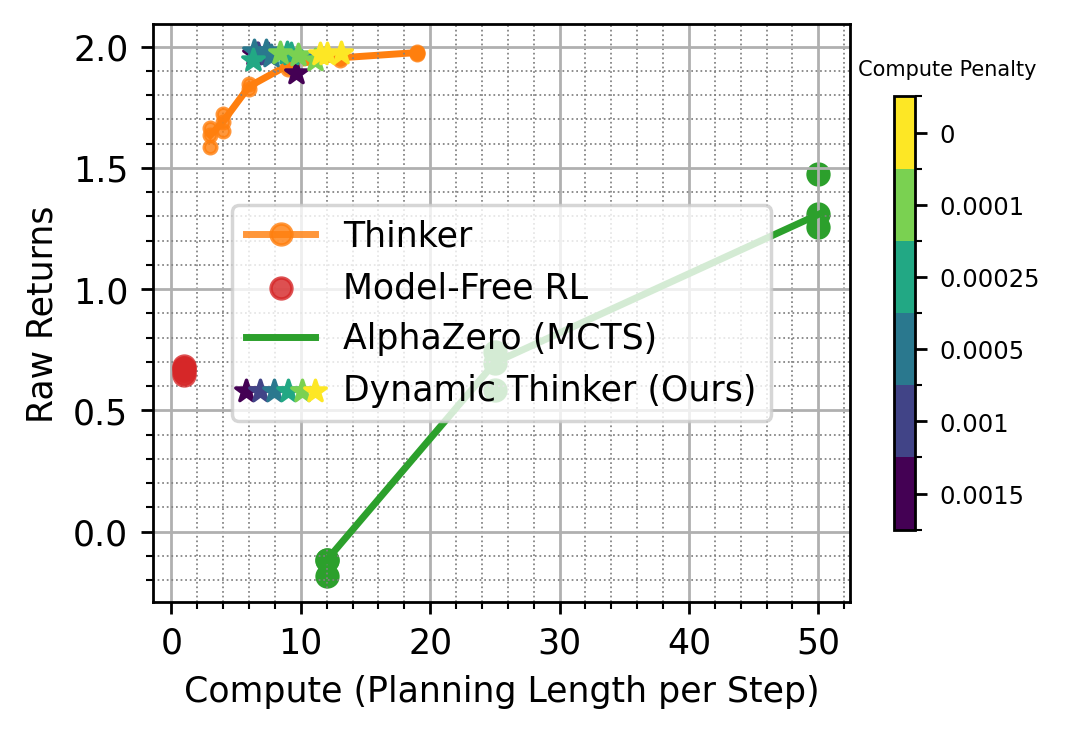

In [16]:
X_LABEL = '_step'
X_FROM, X_TO = 6300000, 6400000
TITLE = f"{human_readable_env_names[subset_sum_bonus.env_name]} Returns after Training"
# for 6.4M Real Steps"

subset_sum_bonus.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                             plot_mcts=False, plot_model_free_rl=False, plot_rectangles=False,
                             plot_line_flexible=True, plot_avg=False, use_title=False)
subset_sum_bonus.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                             plot_mcts=True, plot_model_free_rl=True, plot_rectangles=False,
                             plot_line_flexible=True, plot_avg=False, use_title=False)

49it [00:34,  1.42it/s]


flex -0.002: search 3.0, performance 0.960, n=3
flex -0.0015: search 3.1, performance 0.961, n=5
flex -0.001: search 3.4, performance 0.970, n=4
flex -0.0005: search 4.5, performance 0.976, n=4
flex -0.00025: search 5.7, performance 0.976, n=3
flex -0.0001: search 8.5, performance 0.980, n=3
flex 0: search 8.8, performance 0.982, n=3


43it [00:26,  1.60it/s]
49it [00:00, 18309.21it/s]


flex -0.002: search 3.0, performance 0.960, n=3
flex -0.0015: search 3.1, performance 0.961, n=5
flex -0.001: search 3.4, performance 0.970, n=4
flex -0.0005: search 4.5, performance 0.976, n=4
flex -0.00025: search 5.7, performance 0.976, n=3
flex -0.0001: search 8.5, performance 0.980, n=3
flex 0: search 8.8, performance 0.982, n=3


43it [00:00, 17894.14it/s]
14it [00:05,  2.73it/s]


12 has less than 3 runs (only 2)
25 has less than 3 runs (only 2)


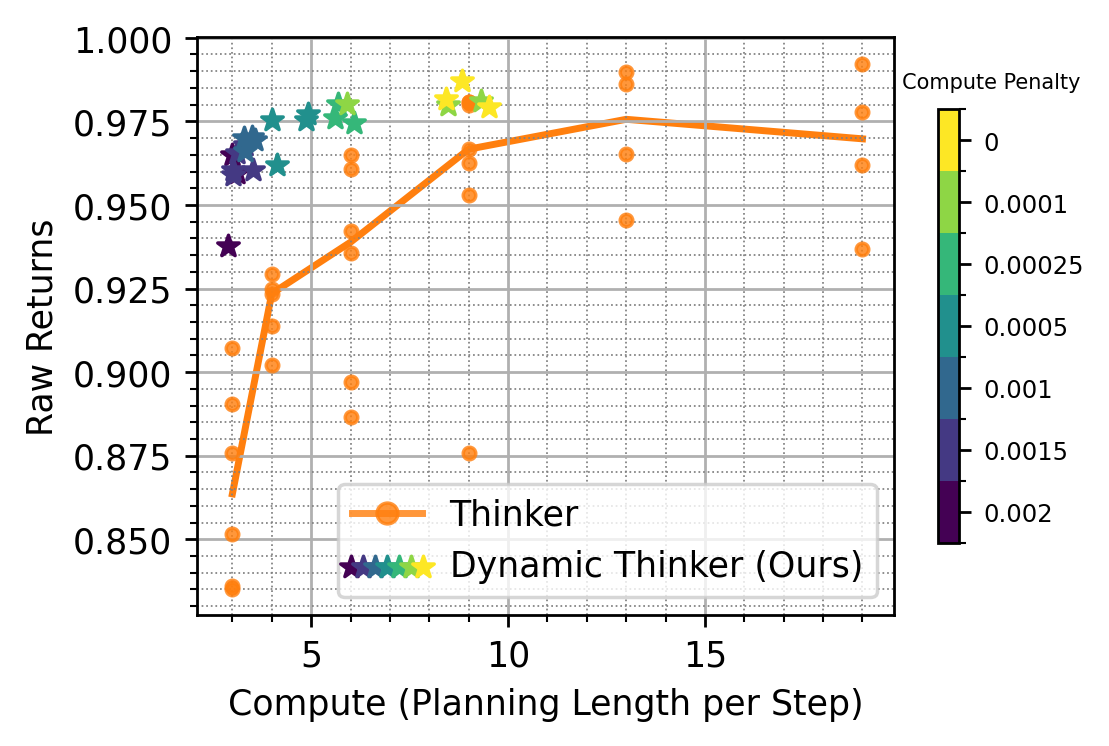

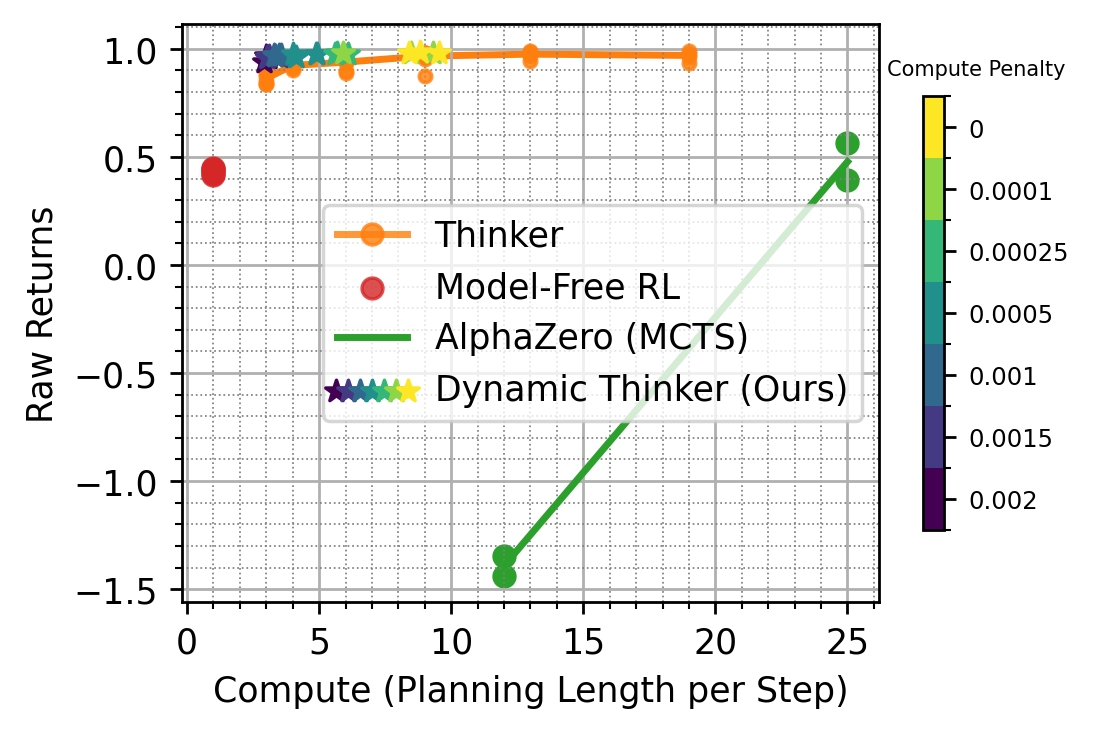

In [17]:
X_LABEL = '_step'
X_FROM, X_TO = 6300000, 6400000
TITLE = f"{human_readable_env_names[knapsack.env_name]} Returns after Training for 6.4M Real Steps"

knapsack.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                     plot_mcts=False, plot_model_free_rl=False, plot_rectangles=False,
                     plot_line_flexible=False, use_title=False)

knapsack.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                     plot_mcts=True, plot_model_free_rl=True, plot_rectangles=False,
                     plot_line_flexible=False, use_title=False)

In [18]:
# X_LABEL = '_step'
# X_FROM, X_TO = 6300000, 6400000
# TITLE = f"{human_readable_env_names[knapsack.env_name]} Returns after Training for 6.4M Real Steps"

# knapsack.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
#                      plot_mcts=False, plot_model_free_rl=False, plot_rectangles=False,
#                      deprecated_xval=True)

100it [01:17,  1.28it/s]


flex -0.008: search 3.8, performance 1.429, n=3
flex -0.004: search 7.2, performance 1.856, n=4
flex -0.002: search 6.8, performance 1.956, n=3
flex -0.0015: search 6.6, performance 1.953, n=3
flex -0.001: search 6.9, performance 1.951, n=3
flex -0.0005: search 7.2, performance 1.946, n=3
flex -0.00025: search 7.4, performance 1.941, n=4
flex 0: search 7.2, performance 1.947, n=3


18it [00:12,  1.42it/s]
100it [00:00, 19971.93it/s]


flex -0.008: search 3.8, performance 1.429, n=3
flex -0.004: search 7.2, performance 1.856, n=4
flex -0.002: search 6.8, performance 1.956, n=3
flex -0.0015: search 6.6, performance 1.953, n=3
flex -0.001: search 6.9, performance 1.951, n=3
flex -0.0005: search 7.2, performance 1.946, n=3
flex -0.00025: search 7.4, performance 1.941, n=4
flex 0: search 7.2, performance 1.947, n=3


18it [00:00, 16560.09it/s]
8it [00:04,  1.80it/s]


Model-Free RL has less than 3 runs (only 2)


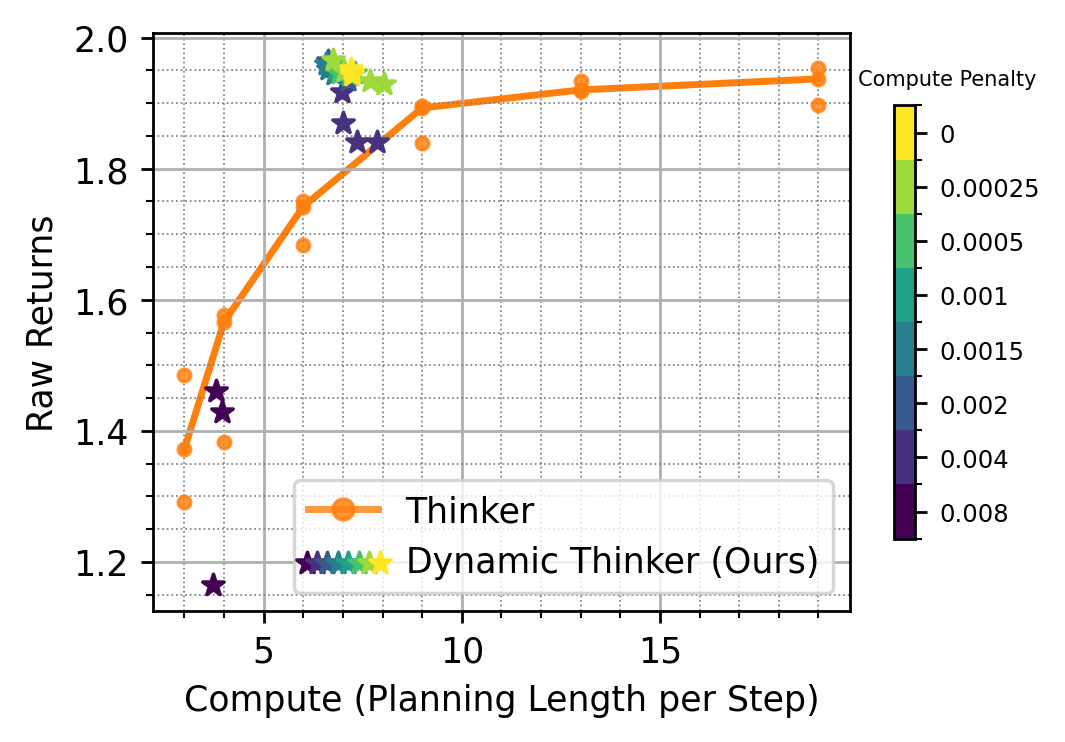

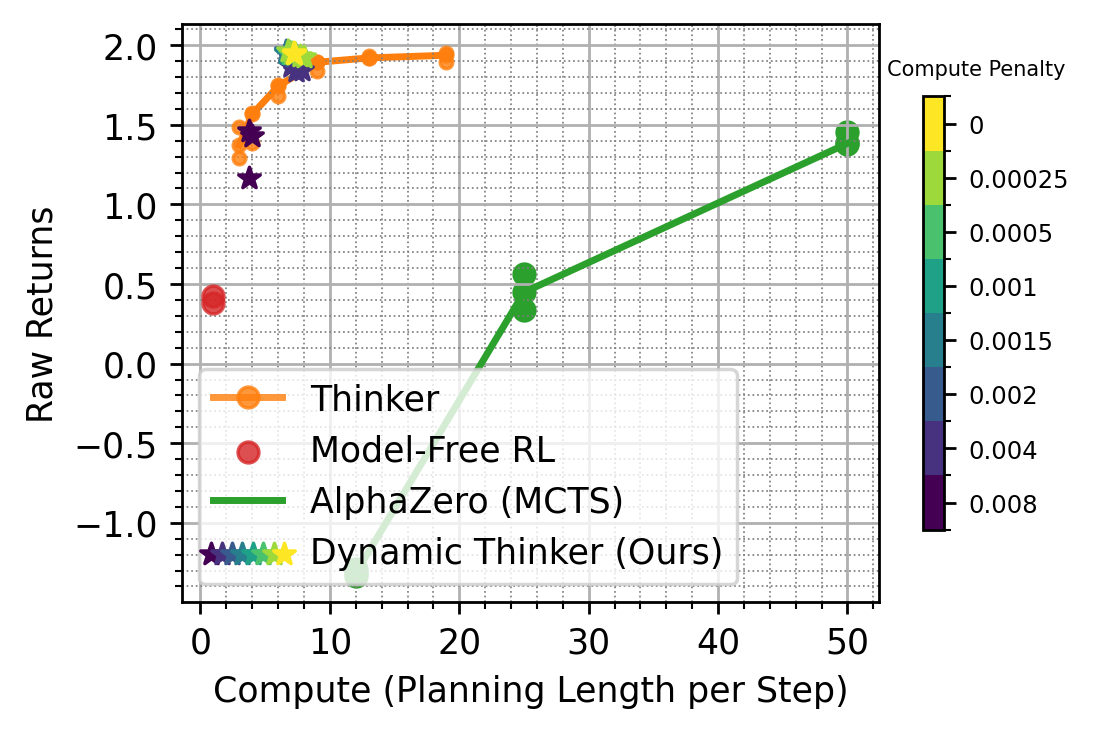

In [19]:
X_LABEL = '_step'
X_FROM, X_TO = 6300000, 6400000
TITLE = f"{human_readable_env_names[knapsack_bonus.env_name]} Returns after Training"
# for 6.4M Real Steps"

knapsack_bonus.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                           plot_mcts=False, plot_model_free_rl=False, plot_rectangles=False,
                           plot_line_flexible=False, plot_avg=False, use_title=False)

knapsack_bonus.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median, 'steps_per_real_step',
                           plot_mcts=True, plot_model_free_rl=True, plot_rectangles=False,
                           plot_line_flexible=False, plot_avg=False, use_title=False)

27it [00:21,  1.28it/s]


flex -0.008: search 7.6, performance 2.322, n=3
flex -0.004: search 8.2, performance 2.702, n=3
flex -0.002: search 8.7, performance 2.806, n=3
flex -0.0015: search 8.7, performance 2.838, n=3
flex -0.001: search 9.4, performance 2.745, n=3
-0.0005 has less than 3 runs (only 2)
flex -0.0005: search 9.4, performance 2.841, n=2
flex -0.00025: search 19.6, performance 2.737, n=3
flex -0.0001: search 19.4, performance 2.760, n=3
flex 0: search 19.9, performance 2.709, n=3


5it [00:03,  1.35it/s]wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=35 sec). Create a new API with an integer timeout larger than 35, e.g., `api = wandb.Api(timeout=45)` to increase the graphql timeout.
5it [25:53, 310.74s/it]


CommError: HTTPSConnectionPool(host='api.wandb.ai', port=443): Read timed out. (read timeout=35)

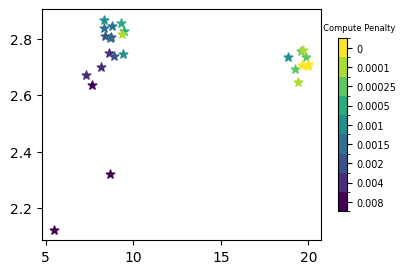

In [20]:
X_LABEL = '_step'
X_FROM, X_TO = 6300000, 6400000
TITLE = f"{human_readable_env_names[knapsack_bonus2.env_name]} Returns after Training"

knapsack_bonus2.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median,
                            'steps_per_real_step', plot_mcts=False, plot_model_free_rl=False,
                            plot_rectangles=False, plot_line_flexible=False, plot_avg=False, use_title=False)

knapsack_bonus2.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median,
                            'steps_per_real_step', plot_mcts=True, plot_model_free_rl=True,
                            plot_rectangles=False, plot_line_flexible=False, plot_avg=False, use_title=False)

In [ ]:
X_LABEL = '_step'
X_FROM, X_TO = 6300000, 6400000
TITLE = f"{human_readable_env_names[knapsack_bonus2_lm.env_name]}, Learned Model Returns after Training"

knapsack_bonus2_lm.plot_pareto(X_LABEL, X_FROM, X_TO, TITLE, median,
                            'steps_per_real_step', plot_mcts=False, plot_model_free_rl=True,
                               plot_rectangles=False, plot_line_flexible=False, use_title=False)

In [ ]:
knapsack.plot_adj_returns('_step', x_to=6400000, ylim_min=0, ylim_max=1)

In [ ]:
knapsack_bonus.plot_adj_returns('_step', x_to=6400000, ylim_min=-0.2, ylim_max=2)
knapsack_bonus.plot_adj_returns('_step', x_to=6400000, ylim_min=-0.2, ylim_max=2, penalties=[-0.002])

In [ ]:
knapsack_bonus2.plot_adj_returns('_step', x_to=6400000)

In [ ]:
sokoban.plot_adj_returns('_step', x_to=30000000, ylim_max=14)

In [ ]:
subset_sum.plot_adj_returns('_step', x_to=6400000, ylim_min=0.6, ylim_max=1)

In [32]:
print('hi')

hi
